# Air Sac Tracking Prototype code
Lara S. Burchardt & Wim Pouw

lara.burchardt@donders.ru.nl

Next to body movements and acoustics, we would also like to track the air sac's inflation of the Siamangs. The air sac naturally forms a spherical(3D) or circular (2D) shape, and such shapes are retrievable from an image using the hough transform, and a bit of pre-processing of the images to get the optimal representation of the relevent edges of the air sac.

This code takes as input a sample video with a close up of a Siamang, and then tracks the air sac when it takes a sufficiently circular shape. The result is shown below; it is not perfect, but with a bit of smoothing this can function as a good air sac tracker. This code is very much under development, there are many ways to improve further.

In [4]:
# import the necessary packages
import numpy as np
import argparse
import cv2
import pandas as pd
from skimage import io, feature, color, measure, draw, img_as_float
import numpy as np
import csv
import random2
import statistics
import scipy
from scipy import signal
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

#resused code from 
#https://pyimagesearch.com/2014/07/21/detecting-circles-images-using-opencv-hough-circles/
#https://stackoverflow.com/questions/31705355/how-to-detect-circlular-region-in-images-and-centre-it-with-python

## Circular Tracker

First approach: Using a video sample as input, the user first defines a region of interest in which to look for circular objects.
After a few pre-processing steps to increase tracking success, the Hough Transform is used to find circles. 
The radius and position of the circle is saved together with the used parameter combination used in pre-processing and tracking. 

Optimized approach: run hough circles transform on 50 random images of the video without roi, let tracked data define the roi for the actual tracking --> selfoptimizing the hough transform 


To do:

- run analysis on the six videos that were used for manual tracking, compare results
- code some smoothing on x, y and radius of the tracking as post-processing (Wim mentioned butterworth for example) 

In [86]:
# before running a different video remove the necessary dataframes etc. from memory 

del df_round_1, df, df2 


NameError: name 'df' is not defined

In [10]:
# preprocessing, choosing a roi on the tracking results of 50 random samples from input file

#https://github.com/patchy631/machine-learning/blob/main/computer_vision/cv2_edge_detection.ipynb

videofolder= '../Video/'
videofilename = 'June16_20.mp4'
# Opens the Video file
cap = cv2.VideoCapture(videofolder+videofilename)
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

frameWidth = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
frameHeight = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
fps = cap.get(cv2.CAP_PROP_FPS)   #fps = frames per second


#set up empty output dataframe
column_names = ['x','y', 'r', 'frame'] # what do we need to save from this?  
df_round_1 = pd.DataFrame(columns = column_names)

# initialize parameters for pre-processing (used in cv2.convertScaleAbs)
alpha = 2 #1.5
beta = 20 #30

#croppedFrame = frame[int(roi[1]): int(roi[1]+roi[3]),
#                     int(roi[0]):int(roi[0]+roi[2])] 

#we define a sequence of 50 ints first, with random numbers of "totalFrames" using sample() because that is sampling without replacement
# then we loop over that list of numbers
# we need an if to check, whether there is >= 50 frames in the video

vector = range(0, int(totalFrames), 1)
samp = random2.sample(vector, 50)
#samp = random2.sample(vector, int(totalFrames))

for rand in samp:
  
    # set frame position
    #samp = samp[rand]
    #samp = float(samp)
    cap.set(cv2.CAP_PROP_POS_FRAMES,rand)
    ret, frame = cap.read()
   # do we need to save which frames were used?

         
    ############################detect circles   
    output=frame.copy()
    # transform to grayscale image only using the roi part of the image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    output_gray=gray.copy()
    # increasing brightness and contrast
    gray_light = cv2.convertScaleAbs(gray, alpha=alpha, beta=beta)
    # apply GuassianBlur to reduce noise. medianBlur is also added for smoothening, reducing noise.
    #gray = cv2.GaussianBlur(gray_light,(11,11),0)
    # Calculate mean intensity
    mean_intensity = np.median(gray)
    # Set thresholds to be one standard deviation above and below median intensity
    threshold1 = int(max(0, (1.0 - 0.33) * mean_intensity))
    threshold2 = int(min(255, (1.0 + 0.33) * mean_intensity))
    
    gray = cv2.medianBlur(gray_light, 19)
    ##thresholded edge contouring
    #hist = cv2.equalizeHist(gray)
    #gamma = 2
    #invGamma = 1/gamma
    #table = np.array([((i / 255.0) ** invGamma) * 255
    #                  for i in np.arange(0, 256)]).astype("uint8")
    #gamm = cv2.LUT(hist, table, hist)
  
    # Apply canny edge detector with dynamic threshold
    #submitted = cv2.Canny(gamm, threshold1, threshold2)
    submitted = cv2.Canny(gray, threshold1, threshold2)
    #submitted = cv2.Canny(gamm, 20, 30)        # was 10 and 50    # why is minVal bigger than maxValue? original code was (gamm, 20, 10)
    #submitted = cv2.GaussianBlur(submitted,(7,7),0)
    #submitted = cv2.threshold(submitted, 25, 255, cv2.THRESH_BINARY)[1]
    submitted = cv2.dilate(submitted, None, iterations=9)  
    #submitted = cv2.erode(submitted, None, iterations=10) 
    submitted = cv2.GaussianBlur(submitted,(7,7),0) 
    #submitted = cv2.erode(submitted, None, iterations=5) #iterations was 4
    
    #track demicircles 
    # define parameters for HoughTransform outside of function to be able to save and manipulate easier
    
    dp = 1
    minDist = 10000
    param1 = 10
    param2 = 22 # war 10
    minRadius = 5
    maxRadius = 250
    
    # original values: dp = 1, minDist = 10000, param1=1, param2=10, minRadius = 5, maxRadius= 250
    circles = cv2.HoughCircles(submitted, cv2.HOUGH_GRADIENT, 
                               dp = dp,minDist = minDist,  
                               param1 = param1,param2 = param2, 
                               minRadius = minRadius, maxRadius = maxRadius)
    #if circles is not None:
    #    circles = np.round(circles[0, 0:1]).astype("int")
    if circles is not None:
        #circles = np.round(circles[0, 0:1]).astype("int")
        if circles is not None:
            circles = np.round(circles[0, 0:1]).astype("int")
            circle1 = circles[0,0]
            circle2 = circles[0,1]
            circle3 = circles[0,2]
        #save it to a row
        if circles is None:
            circle1 = "NA"
            circle2 = "NA"
            circle3 = "NA"
        #for (x, y, r) in circles:
            #cv2.circle(output, (x, y), r, (255, 255, 0), 2) #version without drwaing roi back on whole image
        #    cv2.circle(output[int(roi[1]): int(roi[1]+roi[3]),
        #             int(roi[0]):int(roi[0]+roi[2])], (x, y), r, (255, 255, 0), 2)
        #    cv2.circle(submitted, (x, y), r, (200, 0, 0), 2)
            #print(x,y,r)
    cv2.waitKey(1)
    #out.write(output)
    #cv2.imshow("output", submitted)

# canny min and max value should be added here, if they turn out to be sensitive
    new_row = [circles[0,0], circles[0,1],circles [0,2], rand]
    
    df_round_1.loc[len(df_round_1)] = new_row
    
    median_x = df_round_1['x'].median() #order in pos : same as in original dataframe, so x,y, r
    median_y = df_round_1['y'].median()
    max_r = df_round_1['r'].max()
    min_r = df_round_1['r'].min()
    # order of parameters saved as roi with cv2.selectROI [Top_Left_X, Top_Left_Y, Width, Height]
    # if we want to have a consistent syntax with that, we also need those 4 parameters
   
    # explanation: height_1 is the maximum radius detected plus 20 pixels, that is used to determine the position of the 
    # upper left corner of the roi, same goes for width_1, both are currently the same, but that could change, so they are both
    # coded independently
    height_1 = max_r + 30
    width_1 = max_r + 30
    pos_x = median_x - width_1
    pos_y = median_y - height_1
    
    # to be consistent with the roi nomenclature, we then calculate the width/height of the whole roi which is width_1 *2
    # all those values will then be used to crop picture in next round of tracking
    
    width_2 = width_1 * 2
    height_2 = height_1 *2
    
    
            
# cleaning up
#out.release()
cap.release()
cv2.destroyAllWindows()

TypeError: 'NoneType' object is not subscriptable

In [18]:
videofolder= '../Video/'
videofilename = 'June16_20.mp4'
# Opens the Video file
cap = cv2.VideoCapture(videofolder+videofilename)
frameWidth = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
frameHeight = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
fps = cap.get(cv2.CAP_PROP_FPS)   #fps = frames per second

#output video
out = cv2.VideoWriter('./Output/output_'+videofilename,cv2.VideoWriter_fourcc(*'MP4V'), fps, 
                      (int(frameWidth), int(frameHeight)))
out_2 = cv2.VideoWriter('./Output/output_processed_'+videofilename,cv2.VideoWriter_fourcc(*'MP4V'), fps, 
                      (int(frameWidth), int(frameHeight)))
#set up empty output dataframe
column_names = ['frame','roi_x1','roi_y1','roi_x2', 'roi_y2', # info on region of interest for repetability
                'x','y', 'r', 'inputvideo','input_id',                    # actual results 
                'alpha', 'beta',                              # values of brightness and contrast pre processing
                'dp', 'minDist', 'param1', 'param2', 'minRadius',' maxRadius'] # parameters of hough circle transform 
df = pd.DataFrame(columns = column_names)

#initialize iterator
i=0
# initialize parameters for pre-processing (used in cv2.convertScaleAbs)
alpha = 2 #1.5
beta = 20 #30

# ROI, define a region of interest by mouse click on the first frame
#ret,frame = cap.read()
    # select ROI
#roi  = cv2.selectROI('select the area', frame)

# order of parameters saved as roi with cv2.selectROI [Top_Left_X, Top_Left_Y, Width, Height]
#roi = [821, 351, 612, 488]       # if you want to re run a particular roi, input the roi values here

#croppedFrame = frame[int(roi[1]): int(roi[1]+roi[3]),
#                     int(roi[0]):int(roi[0]+roi[2])] 

roi = [pos_x, pos_y, width_2, height_2]

#main loop                      
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
          
  ############################detect circles   
    output=frame.copy()
    # transform to grayscale image only using the roi part of the image
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    output_gray=gray.copy()
    # increasing brightness and contrast
    gray_light = cv2.convertScaleAbs(gray, alpha=alpha, beta=beta)
    # apply GuassianBlur to reduce noise. medianBlur is also added for smoothening, reducing noise.
    #gray = cv2.GaussianBlur(gray_light,(11,11),0)
    # Calculate mean intensity
    mean_intensity = np.median(gray)
    # Set thresholds to be one standard deviation above and below median intensity
    threshold1 = int(max(0, (1.0 - 0.33) * mean_intensity))
    threshold2 = int(min(255, (1.0 + 0.33) * mean_intensity))
    
    gray = cv2.medianBlur(gray_light, 19)
    ##thresholded edge contouring
    #hist = cv2.equalizeHist(gray)
    #gamma = 2
    #invGamma = 1/gamma
    #table = np.array([((i / 255.0) ** invGamma) * 255
    #                  for i in np.arange(0, 256)]).astype("uint8")
    #gamm = cv2.LUT(hist, table, hist)
  
    # Apply canny edge detector with dynamic threshold
    #submitted = cv2.Canny(gamm, threshold1, threshold2)
    submitted = cv2.Canny(gray, threshold1, threshold2)
    #submitted = cv2.Canny(gamm, 20, 30)        # was 10 and 50    # why is minVal bigger than maxValue? original code was (gamm, 20, 10)
    #submitted = cv2.GaussianBlur(submitted,(7,7),0)
    #submitted = cv2.threshold(submitted, 25, 255, cv2.THRESH_BINARY)[1]
    submitted = cv2.dilate(submitted, None, iterations=9)  
    #submitted = cv2.erode(submitted, None, iterations=10) 
    submitted = cv2.GaussianBlur(submitted,(7,7),0) 
    #submitted = cv2.erode(submitted, None, iterations=5) #iterations was 4
    
    #track demicircles 
    # define parameters for HoughTransform outside of function to be able to save and manipulate easier
    
    dp = 1
    minDist = 10000
    param1 = 10
    param2 = 22 # was 10
    minRadius = min_r - 10
    maxRadius = 270
    name = 'framenr_' + str(i+1) + '_framevid_' + videofilename[0:-4] 
    
    # original values: dp = 1, minDist = 10000, param1=1, param2=10, minRadius = 5, maxRadius= 250
    circles = cv2.HoughCircles(submitted, cv2.HOUGH_GRADIENT, 
                               dp = dp,minDist = minDist,  
                               param1 = param1,param2 = param2, 
                               minRadius = minRadius, maxRadius = maxRadius)
    if circles is not None:
        #circles = np.round(circles[0, 0:1]).astype("int")
        if circles is not None:
            circles = np.round(circles[0, 0:1]).astype("int")
            circle1 = circles[0,0]
            circle2 = circles[0,1]
            circle3 = circles[0,2]
        #save it to a row
        if circles is None:
            circle1 = "NA"
            circle2 = "NA"
            circle3 = "NA"
            
        # code for drawing the found circles onto the original video    
        for (x, y, r) in circles:
            cv2.circle(output, (x, y), r, (255, 255, 0), 2) #version without drawing roi back on whole image
            #cv2.circle(output[int(roi[1]): int(roi[1]+roi[3]),
            #         int(roi[0]):int(roi[0]+roi[2])], (x, y), r, (255, 255, 0), 2)
            cv2.circle(submitted, (x, y), r, (200, 0, 0), 2)
            #print(x,y,r)
    cv2.waitKey(1)
    out.write(output)
    out_2.write(submitted)
    cv2.imshow("output", submitted)
    i=i+1

# saving results and used parameters row wise during loop into a dataframe

# canny min and max value should be added here, if they turn out to be sensitive
    new_row = [i+1, roi[0],roi[1], roi[2], roi[3], circle1, circle2,circle3, videofilename, name,
               alpha, beta, dp, minDist, param1, param2, minRadius, maxRadius]
    
    df.loc[len(df)] = new_row

# filename and saving dataframe as cvs file       
filename =  'airsacradius_results_' + videofilename + '.csv'
df.to_csv(filename, sep = ',')

# cleaning up
out.release()
cap.release()
cv2.destroyAllWindows()

In [55]:
#smoothing of x,y and r of circles
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html
#read raw data
videofolder= '../Video/'
videofilename = 'June16_20.mp4'
filename =  'airsacradius_results_' + videofilename + '.csv'
dfraw = pd.read_csv(filename)
# Opens the Video file
cap = cv2.VideoCapture(videofolder+videofilename)
fps = cap.get(cv2.CAP_PROP_FPS) 
frameWidth = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
frameHeight = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

#outputfile smoothed
out_smoothed = cv2.VideoWriter('./Output/output_smoothed'+videofilename,cv2.VideoWriter_fourcc(*'MP4V'), fps, 
                      (int(frameWidth), int(frameHeight)))


#delete outliers
#how? dynamic? mean +- 2*std of position of centroid in x or y direction? everything under or over that will be deleted
# calculate euclidean distance? to take x and y into account? 

# filter version using butterworth filter
#b, a = scipy.signal.butter(8, 3,'low', fs = 25)
        
#smooth_x = scipy.signal.filtfilt(b, a, dfraw['x'], axis=- 1, padtype='odd', padlen=None, method='pad', irlen=None)  
#smooth_y = scipy.signal.filtfilt(b, a, dfraw['y'], axis=- 1, padtype='odd', padlen=None, method='pad', irlen=None)
#smooth_r = scipy.signal.filtfilt(b, a, dfraw['r'], axis=- 1, padtype='odd', padlen=None, method='pad', irlen=None)

#filter version using Savitzky-golay filter
wl = 11 #windowlength for savgol filter, must be odd
p = 2   # polynomial for savgol filter, must be less than window_length

smooth_x = savgol_filter(dfraw['x'], window_length=wl, polyorder=p)
smooth_y = savgol_filter(dfraw['y'], window_length=wl, polyorder=p)
smooth_r = savgol_filter(dfraw['r'], window_length=wl, polyorder=p)


circles_draw = list(np.column_stack((smooth_x, smooth_y, smooth_r)))


name = dfraw['input_id']
circles_save = list(np.column_stack((smooth_x, smooth_y, smooth_r, name)))
raw_circles = list(np.column_stack((dfraw['x'], dfraw['y'], dfraw['r'])))

column_names = ['x', 'y', 'r', 'inputfile']


df2 = pd.DataFrame(circles_save, columns = column_names)
filename =  'airsacradius_results_smoothed' + videofilename + '.csv'
df2.to_csv(filename, sep = ',')

i = 0
while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret == False:
        break
    output=frame.copy()
    x,y,r = circles_draw[i]
    a,b,c = raw_circles[i]
    #cv2.circle(output[int(roi[1]): int(roi[1]+roi[3]),
    #                 int(roi[0]):int(roi[0]+roi[2])], (int(x), int(y)), int(r), (255, 255, 0), 2)
    cv2.circle(output,(int(x), int(y)), int(r), (255, 255, 0), 2) #blue circle smoothed (color code is the three integers in round brackets)
    cv2.circle(output,(int(a), int(b)), int(c), (0, 0, 255), 2)   # red circle raw
    #coordinates to draw roi, NOT SURE ROI IS WORKING RIGHT NOW!
    cv2.rectangle(output,(int(roi[0]), int(roi[1])),
                     (int(roi[0]+roi[2]), int(roi[1]+roi[3])), (0,0,0), 2)
    i = i+1
            
    #cv2.imshow("output", output)
    out_smoothed.write(output)

    
    
# cleaning up
out_smoothed.release()
cap.release()
cv2.destroyAllWindows()

#other filter option: savgoy filter
#from scipy.signal import savgol_filter
#def savgol(x, wl=14, p=2):
#    return savgol_filter(x, window_length=wl, polyorder=p)


# to do: filtering is too heavy with (8,0.125) check other combinations, also check whether filter is set correctly for
# our sampling rate --> changed that, fs is now in the function, what does the 8 mean? 
# automatic roi seems to be amiss quite heavily for all videos but 16_20...check again how to improve
# we need to read in roi from the data sheet, otherwise weird things can happen

906.0
958.603550295858
321.9425576488327


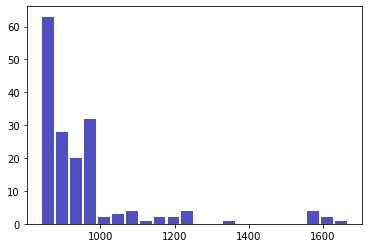

In [48]:
print(dfraw['x'].median())

print(dfraw['x'].mean())
print(2*dfraw['x'].std())
np.histogram(dfraw['x'])


n, bins, patches = plt.hist(x=dfraw['x'], bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)

In [35]:
# to do:

#save smoothed parameters in a way, that per row ( i.e. per frame) framenr and videoname are saved in the
# format of the manually tracked ones: framenr_1_framevid_June09_01.jpeg
# --> delete the jpeg part in the manully tracked ones, built the name for the saving by pasting it together

#'framenr_' + i + '_framevid_' + videofilename 

#something like that, check whether it has to be i-1, because of how python indexes and how we start counting


# Code to track manually labeled image sequences

We can't use the ROI here, as very different images are in the sequence, so that the roi doesn't work.

Currently this doesn't work at all, only one example scene (comprised of multiple images) in batch 1 was tracked well

## Finding the best parameter combination

In this section we try different parameter combinations for pre-processing and tracking to find the parameter combination giving the highest correlation coefficient with the manually tracked results.

Parameters to differ:
- alpha (0.5;1;1.5;2)
- beta  (10,20,30,40,50)
- param2 (Hough Transform) (5;10;15;20)
- eroding iterations (first time: 6,7,8,9,10,11,12; second time: 2,3,4,5,6)
- canny parameters min 5,10,15,20,25,30 max 30,35,40,45,50,55,60

### To do:

1. combine 24 frames of manually tracked frames into video sequence (without the manuall track), 3 frames from all 6 videos?
2. define saving routine
3. define loops for different parameter combinations
4. calculate correlation coefficients for all combinations and manually tracked radii. (maybe in different program) 
5. choose 5 parameters spaces with best correlation coefficient, rerun with roi to see whether there is an increase


In [ ]:
videofolder= '../Video/'
videofilename = 'video_batch_01.mp4'

column_names = ['frame','x','y', 'r', 'inputfile',                                    # actual results 
                'alpha', 'beta','canny_min', 'canny_max','erode_it_1','erode_it_2',   # values of brightness and contrast pre processing
                'param2']                                                             # parameters of hough circle transform 




# constants (define parameters for HoughTransform outside of function to be able to save and manipulate easier)
dp = 1
minDist = 10000
param1 = 10
# param2 is defined in loops
minRadius = 5
maxRadius = 250

# set up dataframe to save results 
global df
df = pd.DataFrame(columns = column_names)         

# loops for different parameter combinations
for alpha in [0.5,1,1.5,2]:
#for alpha in [0.5]:
    for beta in [10,20,30,40,50,60]:
    #for beta in [10]:
        for canny_min in [5,10,15,20,25,30]:
        #for canny_min in [5]:
            for canny_max in [30,35,40,45,50,55,60]:
            #for canny_max in [30]:
                for erode_it_1 in [6,7,8,9,10,11,12]:
                #for erode_it_1 in [10]:
                    for erode_it_2 in [2,3,4,5,6]:
                    #for erode_it_2 in [2]:                     
                        for param2 in [5,10,15,20]:
                            # Opens the Video file
                            cap = cv2.VideoCapture(videofolder+videofilename)
                            frameWidth = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
                            frameHeight = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
                            fps = cap.get(cv2.CAP_PROP_FPS)   #fps = frames per second
                            #initialize iterator
                            i=0
                            while(cap.isOpened()):
                                ret, frame = cap.read()
                                if ret == False:
                                    break
                                ############################detect circles   
                                output=frame.copy()
                                # transform to grayscale image only using the roi part of the image
                                gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                                output_gray=gray.copy()
                                # increasing brightness and contrast
                                gray_light = cv2.convertScaleAbs(gray, alpha=alpha, beta=beta)
                                # apply GuassianBlur to reduce noise. medianBlur is also added for smoothening, reducing noise.
                                gray = cv2.GaussianBlur(gray_light,(11,11),0)
                                gray = cv2.medianBlur(gray, 19)
                                ##thresholded edge contouring
                                hist = cv2.equalizeHist(gray)
                                gamma = 2
                                invGamma = 1/gamma
                                table = np.array([((i / 255.0) ** invGamma) * 255
                                                  for i in np.arange(0, 256)]).astype("uint8")
                                gamm = cv2.LUT(hist, table, hist)
                                #submitted = cv2.Canny(gamm, 10, 50)            # why is minVal bigger than maxValue? original code was (gamm, 20, 10)
                                submitted = cv2.Canny(gamm, canny_min, canny_max)
                                submitted = cv2.GaussianBlur(submitted,(7,7),0)
                                submitted = cv2.threshold(submitted, 25, 255, cv2.THRESH_BINARY)[1]
                                submitted = cv2.dilate(submitted, None, iterations=9)  
                                #submitted = cv2.erode(submitted, None, iterations=10) 
                                submitted = cv2.erode(submitted, None, iterations=erode_it_1)
                                submitted = cv2.GaussianBlur(submitted,(7,7),0) 
                                #submitted = cv2.erode(submitted, None, iterations=4)
                                submitted = cv2.erode(submitted, None, iterations=erode_it_2)

                                #track demicircles (note original prototype values: dp = 1, minDist = 10000, param1=1, param2=10, minRadius = 5, maxRadius= 250)                              
                                circles = cv2.HoughCircles(submitted, cv2.HOUGH_GRADIENT, 
                                                           dp = dp,minDist = minDist,  
                                                           param1 = param1,param2 = param2, 
                                                           minRadius = minRadius, maxRadius = maxRadius)
                                
                                if circles is not None:
                                    circles = np.round(circles[0, 0:1]).astype("int")
                                cv2.waitKey(1)
                                i=i+1

                                new_row = [i, circles[0,0], circles[0,1],circles [0,2], videofilename, alpha, beta, canny_min, canny_max,erode_it_1,erode_it_2,param2]
                                df.loc[len(df)]=new_row
            
print('done')
#we will save after the loop is done            
videofilename_input = videofilename.split('.')[0]
#filename =  'sens_analysis_' + str(alpha) + '_' + str(beta) + '_' + str(canny_min)+ '_' + str(canny_max) + '_' + str(erode_it_1) + '_' + str(erode_it_2)+ '_' + str(param2) + '_' + videofilename_input + '.csv'
filename = 'sens_analysis_all_comb_' + videofilename_input + '.csv'
df.to_csv(filename, sep = ',')

# cleaning up
cap.release()
cv2.destroyAllWindows()

In [ ]:
# To do

# 1. include timepoints in output
#    for each extracted radius, we also want to have the timepoint in the snippet to be able to correlate it with f0 as analyzed 
#    in praat or else, as we won't have the values for exactly the same timepoints 
#    for that we need the fps, that we already write, then multiply fps with frame number (should be i?) and write into output


#2. check preprocessing steps again,which image is best used for edge detection? using the dynamic thresholds for canny, check
# on that. Myabe the gray_light already works with some eroding
# that is why all the other steps are currently commented
# canny threshold implementation from this link: https://github.com/patchy631/machine-learning/blob/main/computer_vision/cv2_edge_detection.ipynb
# 
# 3. plot raw circle, smoothed circle AND ROI on same image to see how they interact
#

In [6]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
output_gray=gray.copy()
  # increasing brightness and contrast
gray_light = cv2.convertScaleAbs(gray, alpha=alpha, beta=beta)
    # apply GuassianBlur to reduce noise. medianBlur is also added for smoothening, reducing noise.
gray = cv2.GaussianBlur(gray_light,(11,11),0)
   # Calculate mean intensity
mean_intensity = np.median(gray)
    # Set thresholds to be one standard deviation above and below median intensity
threshold1 = int(max(0, (1.0 - 0.33) * mean_intensity))
threshold2 = int(min(255, (1.0 + 0.33) * mean_intensity))

In [49]:
df2.to_csv(filename, sep = ',')

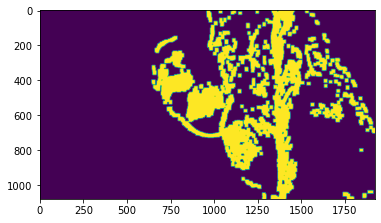

In [75]:
submitted = cv2.Canny(gray_light, threshold1, threshold2)
#submitted = cv2.threshold(submitted, 25, 255, cv2.THRESH_BINARY)[1]
submitted = cv2.dilate(submitted, None, iterations=9)  
#submitted = cv2.erode(submitted, None, iterations=10) 
submitted = cv2.GaussianBlur(submitted,(7,7),0) 
#submitted = cv2.erode(submitted, None, iterations=5) #iterations was 4
plt.imshow(submitted)

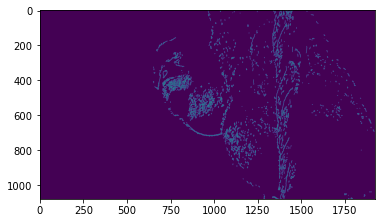

In [65]:
submitted = cv2.Canny(gray_light, threshold1, threshold2)
plt.imshow(submitted)

In [84]:
circles = cv2.HoughCircles(submitted, cv2.HOUGH_GRADIENT, 
                               dp = dp,minDist = minDist,  
                               param1 = param1,param2 = param2, 
                               minRadius = minRadius, maxRadius = maxRadius)

print(circles)

[[[973.5 526.5 187.7]]]


975


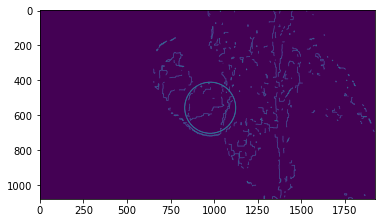

In [85]:
cv2.circle(submitted, (x, y), r, (200, 0, 0), 2)
print(x)
plt.imshow(submitted)

In [77]:
x= int(975.5)
y= int(558.5)
r = int(146.1)

975


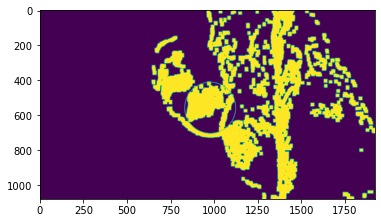

In [78]:
cv2.circle(submitted, (x, y), r, (200, 0, 0), 2)
print(x)
plt.imshow(submitted)

In [26]:
 submitted = cv2.Canny(gray_light, threshold1, threshold2)

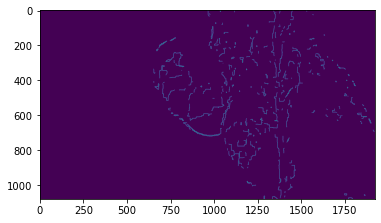

In [82]:
submitted = cv2.Canny(gray_light, threshold1, threshold2)
#submitted = cv2.threshold(submitted, 25, 255, cv2.THRESH_BINARY)[1]
submitted = cv2.GaussianBlur(submitted,(7,7),0)
submitted = cv2.dilate(submitted, None, iterations=9)  
submitted = cv2.erode(submitted, None, iterations=10) 
submitted = cv2.Canny(submitted, threshold1, threshold2)
#submitted = cv2.erode(submitted, None, iterations=5) #iterations was 4
plt.imshow(submitted)

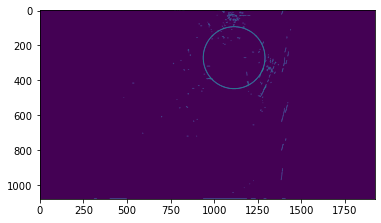

In [36]:
plt.imshow(submitted)

In [17]:
df_round_1

,x,y,r,frame
0,882,496,233,143
1,860,538,223,71
2,858,542,217,81
3,888,490,204,54
4,976,544,179,25
5,930,520,167,50
6,976,550,158,40
